In [2]:
%load_ext autoreload
%autoreload 2

# OS interactions and calls:
import os
import subprocess as sbp
import sys

# direct print output to file:
# logfile_path = 'fc_monthly_plt.log'
# sys.stdout = open(logfile_path, 'w')

# project specific configurations:
from cf_monthly_forecast.config import *
import cf_monthly_forecast.plot_annotations as pla
import cf_monthly_forecast.plot_options_monthly as pom
import cf_monthly_forecast.vis_config as vc
from cf_monthly_forecast.utils import get_varnums,split_longname_into_varnames

# data access
from netCDF4 import Dataset

# data processing
import numpy as np
from scipy import interpolate
from datetime import datetime
from cf_monthly_forecast.smooth2d import box_smooth_2D

# plotting
import matplotlib.pyplot as plt
from cf_monthly_forecast.vis_utils import TWOCOLUMN_WIDTH_INCHES,SubplotFigure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# keep these to False for now:
isrelative = False
quarterly = False

# fontsize:
FS = 9.

# splines used for interpolation
nsplines = 4

In [4]:
# automatically generate date during time of running the script:
# today = datetime.today()
today = datetime(2022,7,15)
initmonth = today.month
inityear = today.year

In [5]:
# generate the expected name of the current forecast file:
if isrelative:
    filename = 'forecast_relative_to_2018_2021_6.nc4'
    figw_inches = TWOCOLUMN_WIDTH_INCHES*.6
else:
    if quarterly:
        filename = '{0:s}/forecast_quarterly_{1:s}_{2:d}.nc4'.format(dirs['SFE_forecast'],str(inityear).zfill(4),initmonth)
    else:
        filename = '{0:s}/forecast_{1:s}_{2:d}.nc4'.format(dirs['SFE_forecast'],str(inityear).zfill(4),initmonth)
    figw_inches = TWOCOLUMN_WIDTH_INCHES*.8

# Check for existence and abort if the file does not exist:
if not os.path.isfile(filename):
    sys.exit()


In [44]:
# define where forecasts are located and where figures should be saved:
figdir = '{0:s}/monthly_fc/init_{1:s}-{2:s}/probabilities/'.format(
        dirs['public'],str(inityear).zfill(4),str(initmonth).zfill(2)
)

# create a folder for the initialization if it doesn't already exist:
if not os.path.exists(figdir):
    os.makedirs(figdir,exist_ok=False) # creates directories recursively!
# make another directory for the smoothed fields:
if not os.path.exists(figdir+'smoothed/'):
    os.makedirs(figdir+'smoothed/',exist_ok=False)

In [7]:
# load data:
ds = Dataset(filename, mode='r')
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
lon,lat = np.meshgrid(lon,lat)

In [8]:
# derive a dictionary pointing from the required variable to the corresponding index in the dataset:
variablenumber = get_varnums(split_longname_into_varnames(ds),pom.variables)
print(variablenumber)

{'t2': 0, 'pr': 1, 'wsp': 5}


In [13]:
# loop over forecast months & note that index 0 is forecast month 1!! (e.g. May init, index 0 has June monthly mean)
FCMONTHS = np.array(ds.variables['leadtime_month'][:],dtype=int)
FCYEARS = []
for mm in FCMONTHS:
    if mm >= initmonth:
        FCYEARS.append(inityear)
    else:
        FCYEARS.append(inityear+1)

# choose a subset of forecast months to plot:
subset = slice(0,1) # None
FCMONTH = FCMONTHS[subset]
FCYEAR = FCYEARS[subset]

8 7 0
ExceedQ33 37.4479742979987
pr 0.0 100.0
linearly interpolating data to 4x the resolution
fc_pr_08_ExceedQ33_EUROPE_en_9gpkernel
/projects/NS9853K/www//monthly_fc/init_2022-07/probabilities/smoothed/fc_pr_08_ExceedQ33_EUROPE_en_9gpkernel.png
fc_pr_08_ExceedQ33_EUROPE_en_25gpkernel


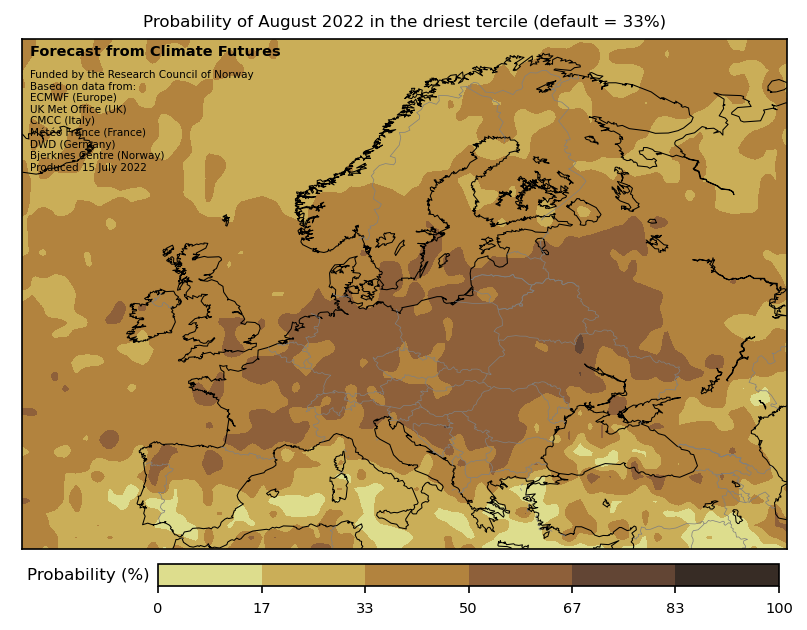

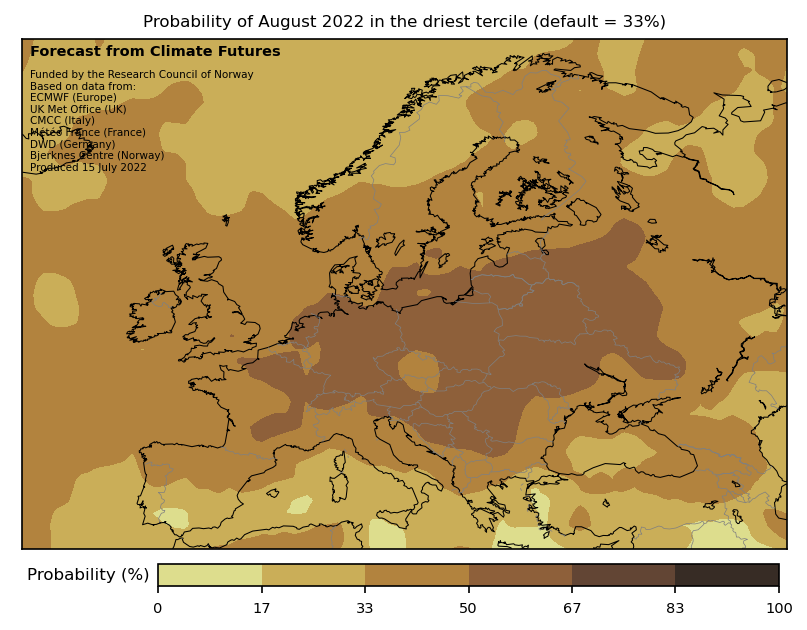

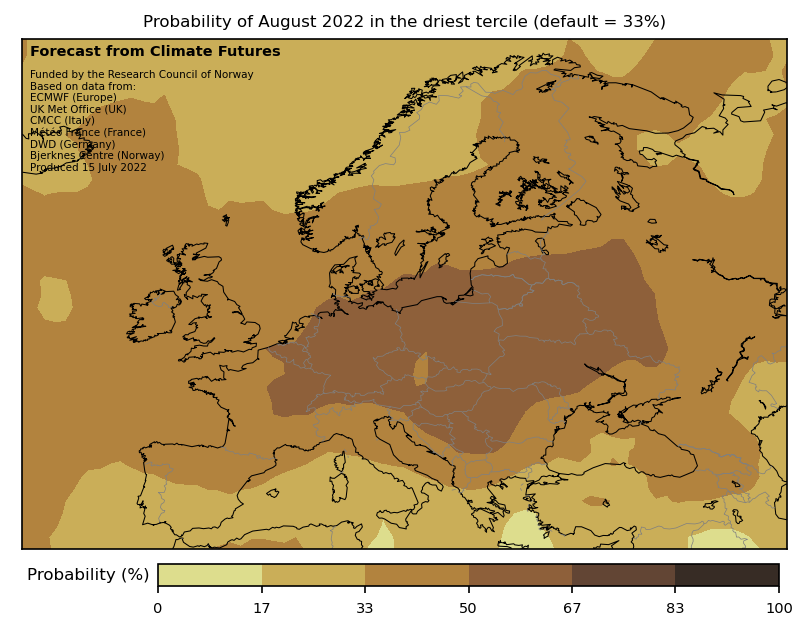

In [46]:
for fcmonth,fcyear in zip(FCMONTH,FCYEAR):

	for variable in pom.variables[1:2]:
		
		for area in pom.DOMAINS[:1]:

			# weights:
			glat0 = 40
			glat1 = 70
			gpoints = np.nonzero((lat.ravel()>=glat0)&(lat.ravel()<=glat1))[0]
			gweights = np.cos(np.radians(lat.ravel()[gpoints]))
			gweights /= np.sum(gweights)
			points = np.nonzero(
				(lon.ravel() >= vc.area_specs[area]['lon0']) & 
				(lon.ravel() <= vc.area_specs[area]['lon1']) &
				(lat.ravel() >= vc.area_specs[area]['lat0']) &
				(lat.ravel() <= vc.area_specs[area]['lat1'])
			)[0]
			weights = np.cos(np.radians(lat.ravel()[points]))
			weights /= np.sum(weights)

			if nsplines:
				lon2 = np.linspace(lon[0,0],lon[0,-1],lon.shape[1]*nsplines)
				lat2 = np.linspace(lat[0,0],lat[-1,0],lat.shape[0]*nsplines)
				lon3,lat3 = np.meshgrid(lon2,lat2)
				xi,yi = vc.area_specs[area]['bm'](lon3,lat3)
			else:
				xi,yi = vc.area_specs[area]['bm'](lon,lat)
				xp,yp = vc.area_specs[area]['bm'](lon-.25,lat-.25)
			for model in pom.models[:1]:
				a = None
				if quarterly:
					a = ds.variables[model][variablenumber[variable],:,:]
				if a is None:
					idx = fcmonth-initmonth-1
					if idx<0:
						idx += 12
					print(fcmonth,initmonth,idx)
					try:
						a = ds.variables[model][variablenumber[variable],idx,:,:]
					except:
						#raise
						a = ds.variables[model][idx,:,:]
				
				# perform smoothing
				sm_field_9 = box_smooth_2D(np.array(a),1,1,latitude=np.array(lat[:,0]))*100
				sm_field_25 = box_smooth_2D(np.array(a),2,2,latitude=np.array(lat[:,0]))*100
				if model in ('ExceedQ33'):
					sm_field_9 = 100 - sm_field_9
					sm_field_25 = 100 - sm_field_25
				
				cv = pom.cvs[model]
				ticks = cv
				fmt = '%.0f'
				try:
					cmapname = pom.cmapnames[model][variable]
				except:
					cmapname = pom.cmapnames[model]
				cmap = plt.get_cmap(cmapname,len(cv)-1)
				a *= 100.
				if model in ('ExceedQ33',):
					a = 100.-a

				# Compute area average:
				gavg = np.sum(a.ravel()[gpoints]*gweights)
				avg = np.sum(a.ravel()[points]*weights)
				print(model,avg)
				
				print(variable,np.min(a),np.max(a))
				for lang in pom.langs:
					mstr = pla.monthnames[lang][fcmonth-1]
					title = ''
					if model in ('ExceedQ67',):
						title = {
							'en': 'Probability of %s %i in the %s tercile (default = 33%%%s)'%(
								mstr,
								fcyear,
								{'t2':'warmest','pr':'wettest','wsp':'windiest'}[variable],
								(', average = %i%%'%(avg+.5) if area=='GLOBAL' else '')
							)
						}[lang]
					elif model in ('ExceedQ50',):
						if quarterly:
							title = {
								'en': 'Estimated probability that %s'%(
									pla.season[lang]
								)
							}[lang]
						else:
							title = {
								'en': 'Estimated probability that %s %i'%(
									mstr,
									fcyear
								)
							}[lang]
						if area == 'GLOBAL':
							t = ', global average: %i%%'%(avg+.5)
						else:
							t = ', average between %iN and %iN: %i%%'%(glat0,glat1,gavg+.5)
						title += {
							'en': ' will be %s than normal\n(default: 50%%%s)'%(
								{'t2':'warmer','pr':'wetter','wsp':'windier'}[variable],
								t
							)
						}[lang]
					elif model in ('ExceedQ33',):
						title = {
							'en': 'Probability of %s %i in the %s tercile (default = 33%%%s)'%(
								mstr,
								fcyear,
								{'t2':'coldest','pr':'driest','wsp':'calmest'}[variable],
								(', average = %i%%'%(avg+.5) if area=='GLOBAL' else '')
							)
						}[lang]
					elif model in ('temperature_exceedance',):
						title = {
							'en': 'Probability that July 2021 will be warmer than July 2018'
						}[lang]
					elif model in ('total_precipitation_exceedance',):
						title = {
							'en': 'Probability that July 2021 will be drier than July 2018'
						}[lang]

					# Initialize Figure:
					fig = SubplotFigure(
						figw_inches = figw_inches,
						aspectratio = vc.area_specs[area]['aspectratio'],
						marginleft_inches = 0.05,
						marginright_inches = 0.05,
						margintop_inches = 0.45,
						marginbottom_inches = 0.05,
						cbar_height_inches = .15,
						cbar_bottompadding_inches = .25,
						cbar_toppadding_inches = .05,
						cbar_width_percent = 95.
					)
					ax = fig.subplot(0)
					# interpolate for smoother contours in the regional figures:
					if nsplines:
						print('linearly interpolating data to {0:d}x the resolution'.format(nsplines))
						f = interpolate.interp2d(lon[0,:], lat[:,0], a, kind='linear')
						a = f(lon2,lat2)

						f2 = interpolate.interp2d(lon[0,:], lat[:,0], sm_field_9, kind='linear')
						sm_field_9i = f2(lon2,lat2)

						f3 = interpolate.interp2d(lon[0,:], lat[:,0], sm_field_25, kind='linear')
						sm_field_25i = f3(lon2,lat2)

					spr = cv[-1]-cv[0]
					a[a<=cv[0]] = cv[0]+ spr/1000.
					a[a>=cv[-1]] = cv[-1]-spr/1000.
					levels = np.arange(cv[0],cv[-1])
					hatches = [None]*(len(cv)-1)
					# Plot probabilities:
					cf = ax.contourf(xi,yi,a,cv,cmap=cmap,vmin=cv[0],vmax=cv[-1],hatches=hatches)
					vc.area_specs[area]['bm'].drawcoastlines(linewidth=.5)
					vc.area_specs[area]['bm'].drawcountries(linewidth=.35,color='.5')
					if not area in ('GLOBAL',):
						tkw = {
							'horizontalalignment':'left',
							'verticalalignment':'top',
							'transform':ax.transAxes
						}
						t1 = '%s'%{'no':'Varsel fra','en':'Forecast from'}[lang]
						t1 += ' Climate Futures'
						plt.text(0.01,.99,t1,fontweight='bold',fontsize=FS-2,**tkw)
						t = {'no':'Finansiert av Forskningsrådet','en':'Funded by the Research Council of Norway'}[lang]
						t += '\n%s:'%{'no':'Basert på data fra','en':'Based on data from'}[lang]
						t += '\nECMWF (%s)'%{'no':'Europa','en':'Europe'}[lang]
						t += '\nUK Met Office (%s)'%{'no':'Storbritannia','en':'UK'}[lang]
						t += '\nCMCC (%s)'%{'no':'Italia','en':'Italy'}[lang]
						t += '\nMétéo France (%s)'%{'no':'Frankrike','en':'France'}[lang]
						t += '\nDWD (%s)'%{'no':'Tyskland','en':'Germany'}[lang]
						t += '\nBjerknes Centre (%s)'%{'no':'Norge','en':'Norway'}[lang]
						t += '\n{0:s} {1:d} {2:s} {3:d}'.format({'no':'Utarbeidet','en':'Produced'}[lang],today.day,pla.monthnames[lang][today.month-1],today.year)
						plt.text(0.01,.94,t,fontsize=FS-4,**tkw)
					plt.title(title,fontsize = FS-1)
					desc = 'Probability (%)'
					rightmargin = 0
					if area in ('GLOBAL',):
						rightmargin = 0.05
					fig.draw_colorbar(
						mappable = cf,
						fontsize=FS-1, 
						cmap = cmap, 
						vmin = cv[0], 
						vmax = cv[-1],
						desc = desc,
						ticks = ticks,
						rightmargin = rightmargin,
						fmt = fmt
					)
					filename = 'fc_{0:s}_{1:s}_{2:s}_{3:s}_{4:s}'.format(
						variable,
						str(fcmonth).zfill(2),
						model,
						area,
						lang
					)
					if quarterly:
						filename += '_q'
					# fig.fig.savefig('{0:s}{1:s}.png'.format(figdir,filename),dpi=300)
					# plt.close(fig.fig)


					# Plot the smoothed fields in addition:
					fig_s1 = SubplotFigure(
						figw_inches = figw_inches,
						aspectratio = vc.area_specs[area]['aspectratio'],
						marginleft_inches = 0.05,
						marginright_inches = 0.05,
						margintop_inches = 0.45,
						marginbottom_inches = 0.05,
						cbar_height_inches = .15,
						cbar_bottompadding_inches = .25,
						cbar_toppadding_inches = .05,
						cbar_width_percent = 95.
					)
					ax_s1 = fig_s1.subplot(0)
					
					xi_s,yi_s = vc.area_specs[area]['bm'](lon,lat)
					sm_field_9[sm_field_9<=cv[0]] = cv[0]+ spr/1000.
					sm_field_9[sm_field_9>=cv[-1]] = cv[-1]-spr/1000.
					# Plot probabilities:
					cf_s1 = ax_s1.contourf(xi,yi,sm_field_9i,cv,cmap=cmap,vmin=cv[0],vmax=cv[-1],hatches=hatches)
					# ax_s1.contour(xi,yi,sm_field_9i,cv,vmin=cv[0],vmax=cv[-1],hatches=hatches)
					vc.area_specs[area]['bm'].drawcoastlines(linewidth=.5)
					vc.area_specs[area]['bm'].drawcountries(linewidth=.35,color='.5')
					if not area in ('GLOBAL',):
						tkw = {
							'horizontalalignment':'left',
							'verticalalignment':'top',
							'transform':ax_s1.transAxes
						}
						plt.text(0.01,.99,t1,fontweight='bold',fontsize=FS-2,**tkw)
						plt.text(0.01,.94,t,fontsize=FS-4,**tkw)
					plt.title(title,fontsize = FS-1)
					fig_s1.draw_colorbar(
						mappable = cf_s1,
						fontsize=FS-1, 
						cmap = cmap, 
						vmin = cv[0], 
						vmax = cv[-1],
						desc = desc,
						ticks = ticks,
						rightmargin = rightmargin,
						fmt = fmt
					)
					filename_sm1 = 'fc_{0:s}_{1:s}_{2:s}_{3:s}_{4:s}_9gpkernel'.format(
						variable,
						str(fcmonth).zfill(2),
						model,
						area,
						lang
					)
					print(filename_sm1)
					if quarterly:
						filename += '_q'
					print('{0:s}smoothed/{1:s}.png'.format(figdir,filename_sm1))
					# fig_s1.fig.savefig('{0:s}smoothed/{1:s}.png'.format(figdir,filename_sm1),dpi=300)
					# plt.close(fig_s1.fig)

					# Plot the more strongly smoothed fields in addition:
					fig_s2 = SubplotFigure(
						figw_inches = figw_inches,
						aspectratio = vc.area_specs[area]['aspectratio'],
						marginleft_inches = 0.05,
						marginright_inches = 0.05,
						margintop_inches = 0.45,
						marginbottom_inches = 0.05,
						cbar_height_inches = .15,
						cbar_bottompadding_inches = .25,
						cbar_toppadding_inches = .05,
						cbar_width_percent = 95.
					)
					ax_s2 = fig_s2.subplot(0)
					
					sm_field_25[sm_field_25<=cv[0]] = cv[0]+ spr/1000.
					sm_field_25[sm_field_25>=cv[-1]] = cv[-1]-spr/1000.
					# Plot probabilities:
					cf_s2 = ax_s2.contourf(xi_s,yi_s,sm_field_25,cv,cmap=cmap,vmin=cv[0],vmax=cv[-1],hatches=hatches)
					vc.area_specs[area]['bm'].drawcoastlines(linewidth=.5)
					vc.area_specs[area]['bm'].drawcountries(linewidth=.35,color='.5')
					if not area in ('GLOBAL',):
						tkw = {
							'horizontalalignment':'left',
							'verticalalignment':'top',
							'transform':ax_s2.transAxes
						}
						plt.text(0.01,.99,t1,fontweight='bold',fontsize=FS-2,**tkw)
						plt.text(0.01,.94,t,fontsize=FS-4,**tkw)
					plt.title(title,fontsize = FS-1)
					fig_s2.draw_colorbar(
						mappable = cf_s2,
						fontsize=FS-1, 
						cmap = cmap, 
						vmin = cv[0], 
						vmax = cv[-1],
						desc = desc,
						ticks = ticks,
						rightmargin = rightmargin,
						fmt = fmt
					)
					filename_sm2 = 'fc_{0:s}_{1:s}_{2:s}_{3:s}_{4:s}_25gpkernel'.format(
						variable,
						str(fcmonth).zfill(2),
						model,
						area,
						lang
					)
					print(filename_sm2)
					if quarterly:
						filename += '_q'
					# fig_s2.fig.savefig('{0:s}smoothed/{1:s}.png'.format(figdir,filename_sm2),dpi=300)
					# plt.close(fig_s2.fig)